<a href="https://colab.research.google.com/github/threewisemonkeys-as/dl_fun/blob/master/oneshot_learning/MNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import random

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
 
import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython.core.debugger import set_trace
    from IPython import display
plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
transform = T.Compose([T.ToTensor(),
                       T.Normalize((0.5,), (0.5,)),
                      ])

trainset = MNIST(root='./data', train=True,
                 download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=4, pin_memory=True)


testset = MNIST(root='./data', train=False,
                download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4)

0it [00:00, ?it/s]

9920512it [00:01, 8123751.34it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 126158.96it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2076304.69it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 47922.80it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


torch.Size([32, 1, 28, 28])


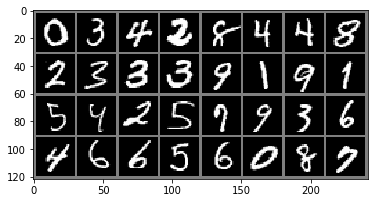

[0, 3, 4, 2, 8, 4, 4, 8, 2, 3, 3, 3, 9, 1, 9, 1, 5, 4, 2, 5, 7, 9, 3, 6, 4, 6, 6, 5, 6, 0, 8, 7]


In [0]:
#imshow = lambda img: plt.imshow(img.numpy().squeeze(), cmap='gray_r');

def imshow(img):
    img = (img / 2) + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

imshow(torchvision.utils.make_grid(images))
print([a.item() for a in labels])

In [0]:
def get_output_shape(input_shape, module, batch_size=1):
    dummy_input = Variable(torch.rand(batch_size, *input_shape, device=device))
    output_feat = module(dummy_input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size


In [0]:
class Net(nn.Module):

  def __init__(self, input_shape):
      super(Net, self).__init__()

      self.feature_extractor = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5), # 1x28x28 --> 32x24x24
              nn.ReLU(),
              nn.MaxPool2d(2, 2), # 32x24x24 --> 32x12x12
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 32x12x12 --> 64x12x12
              nn.ReLU(),
              nn.MaxPool2d(2, 2), # 64x12x12 --> 64x6x6
              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 64x6x6 --> 128x6x6
              nn.ReLU(),
              nn.MaxPool2d(2, 2), # 128x6x6 --> 128x3x3
              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # 128x3x3 --> 256x1x1
          ).to(device)
      
      n_size = get_output_shape(input_shape, module=self.feature_extractor)
      
      self.dense = nn.Sequential(
              nn.Linear(n_size, 1024),
              nn.Linear(1024, 10),
          ).to(device)

  def forward(self, x):
      features = self.feature_extractor(x)
      features = features.view(features.size(0), -1)
      predictions = self.dense(features)

      return predictions


In [0]:
f = Net((1, 28, 28)).to(device)
print(get_output_shape((1, 28, 28), f.feature_extractor))
batch = [trainset[random.randrange(len(trainset))] for _ in range(32)]
images, labels = list(zip(*batch))
labels = torch.tensor(labels, dtype=torch.long, device=device)
d = [i.unsqueeze(0) for i in images]
e = torch.cat(d, 0)
e = e.to(device)

preds = f(e)
preds.shape
l = nn.CrossEntropyLoss()
l(preds, labels)
print(torch.argmax(preds, 1) == labels)
sum(torch.argmax(preds, 1) == labels).item() / 32


256
tensor([False, False, False,  True, False, False, False, False,  True, False,
         True, False, False,  True, False, False, False, False, False, False,
         True, False, False,  True, False,  True, False, False, False, False,
        False,  True], device='cuda:0')


0.25

In [0]:
def test_accuracy(classifier, dataset, BATCH_SIZE):
    classifier.eval()
    batch = [dataset[random.randrange(len(dataset))] for _ in range(BATCH_SIZE)]
    images, labels = list(zip(*batch))
    labels = torch.tensor(labels, dtype=torch.long, device=device)

    preds = classifier((torch.cat([i.unsqueeze(0) for i in images], 0)).to(device))
    acc = sum(torch.argmax(preds, 1) == labels) / BATCH_SIZE

    return acc.item()


def train(classifier, dataset, dataloader, criterion_type, optimizer_type, 
          LEARNING_RATE=0.001, VERBOSE=False):
    criterion = criterion_type().to(device)
    optimizer = optimizer_type(classifier.parameters(), lr=LEARNING_RATE)
    
    print("Starting training proccess ... \n")

    losses = []
    accuracies = []
    n = len(dataloader)
    
    for i_episode, data_elem in enumerate(dataloader):
        classifier.train()
        optimizer.zero_grad()

        images, labels = data_elem
        images, labels = images.to(device), labels.to(device)

        prediction = classifier(images)
        loss = criterion(prediction, labels)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()    

        if (i_episode+1) % (n/20) == 0: 
            accuracies.append(test_accuracy(classifier, dataset, BATCH_SIZE=32))
            if VERBOSE:
                print(f"Episode {i_episode + 1} / {n} ({((i_episode + 1)*100) // n}%) | Current Accuracy: {(accuracies[-1]*100):.2f}% | Running Loss of last 5% ({n // 20}) = {(sum(losses[-(n//20):]) / len(losses[-(n//20):])):.4f}")

        
    print(f"\nComplete!\n")
    plt.plot(losses)

In [0]:
n = Net((1, 28, 28)).to(device)
n

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  )
  (dense): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=10, bias=True)
  )
)

Starting training proccess ... 

Episode 375 / 1875 (20%) | Current Accuracy: 0.00% | Running Loss of last 5% (93) = 0.1084
Episode 750 / 1875 (40%) | Current Accuracy: 0.00% | Running Loss of last 5% (93) = 0.1241
Episode 1125 / 1875 (60%) | Current Accuracy: 0.00% | Running Loss of last 5% (93) = 0.0874
Episode 1500 / 1875 (80%) | Current Accuracy: 0.00% | Running Loss of last 5% (93) = 0.0763
Episode 1875 / 1875 (100%) | Current Accuracy: 100.00% | Running Loss of last 5% (93) = 0.0545

Complete!



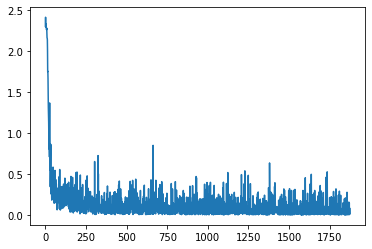

In [0]:
train(classifier=n,
      dataset=trainset,
      dataloader=trainloader,
      criterion_type=nn.CrossEntropyLoss,
      optimizer_type=optim.Adam,
      LEARNING_RATE=0.001,
      VERBOSE=True,
     )

In [0]:
def test(classifier, dataloader):
    accuracies = []
    n = len(dataloader)
        
    for i_episode, data_elem in enumerate(dataloader):
        classifier.eval()

        images, labels = data_elem
        images, labels = images.to(device), labels.to(device)
        

        prediction = classifier(images)
        accuracies.append(sum(torch.argmax(prediction, 1) == labels).item() / 32)


        if (i_episode+1) % (n/20) == 0: 
                print(f"Episode {i_episode + 1} / {n} ({((i_episode + 1)*100) // n}%)")# | Current Accuracy: {(accuracies[-1]*100):.2f}% | Running Loss of last 5% ({n // 20}) = {(sum(losses[-(n//20):]) / len(losses[-(n//20):])):.4f}")

        
    print(sum(accuracies)/len(accuracies) * 100)
    print(f"\nComplete!\n")


In [0]:
test(classifier=n, dataloader=testloader)

98.3326677316294

Complete!



In [0]:
from google.colab import files
torch.save(n.state_dict(), 'mnist_classifier.pth')
files.download('mnist_classifier.pth')